# Auswerten der Adressdaten in Österreich

Das BEV (Bundesamt für Eich- und Vermessungswesen) bietet das öffentlich zugängliche
[Adressregister](https://www.bev.gv.at/portal/page?_pageid=713,2601271&_dad=portal&_schema=PORTAL)
zum Download an. Es besteht aus mehreren CSV Dateien. Wir verwenden die Datei *ADRESSE.csv* aus
dem Archiv *Adresse Relationale Tabellen - Stichtagsdaten 03.04.2022.zip*. Diese Datei liegt bz2
komprimiert im Repository bereit.

Die geografischen Angaben sind nicht mit Längen- und Breitengrad codiert, sondern mit einem eigenen
Koordinatensystem aus der Vermessung. Diese Koordinatensysteme projizieren einen begrenzten Bereich
auf 2D Koordinaten, damit Berechnungen schneller ablaufen. Deswegen verwenden wir das Paket
*pyproj*, um diese Koordinaten umzuwandeln.

In [ ]:
import pyproj                               # pip install pyproj
import pandas as pd
# Von epsg:31256 MGI / Austria GK East (https://epsg.io/31256)
# auf epsg:4326 (GPS)
transformer = pyproj.Transformer.from_crs("epsg:31256", "epsg:4326")
# ADRCD ist eindeutig und wir verwenden ihn als Index für den Dataframe.
addresses = pd.read_csv("ADRESSE.csv.bz2", sep=";", index_col=0, usecols=['ADRCD', 'GKZ', 'PLZ', 'RW', 'HW'])
addresses = addresses[addresses.GKZ == 90001]  # Nur Wien laden
# Die Koordinaten umrechnen und dafür die Spalten LAT und LNG erstellen.
gps = addresses.apply(lambda a: transformer.transform(a.HW, a.RW), axis=1)
addresses[["LAT", "LNG"]] = gps.apply(pd.Series)
addresses[0:10]

Wie viele Adressen gibt es pro PLZ? Die Funktion *value_counts()* ist eine Abkürzung für die
Gruppierung und die *size()* Funktion. *sort_index* sortiert nach dem Index, sonst würden wir nach
der Anzahl sortiert ausgeben.

<AxesSubplot:>

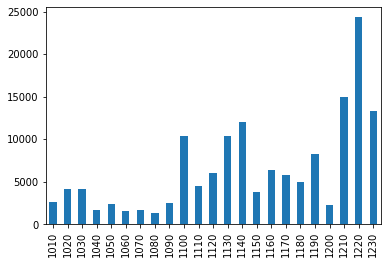

In [106]:
addresses['PLZ'].value_counts().sort_index().plot(kind='bar')

In [105]:
import plotly.express as px   # pip install plotly
counts = addresses[["PLZ", "LAT", "LNG"]].groupby("PLZ") \
    .agg({'LAT': 'mean', 'LNG': 'mean', 'PLZ': 'size'}) \
    .rename(columns={'PLZ': 'COUNT'})
fig = px.scatter_mapbox(counts, lat='LAT', lon='LNG',
                     hover_name="COUNT", color_discrete_sequence=["fuchsia"],
                     height=300)
#fig.update_layout(mapbox_style="open-street-map")                     
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "source": [
                "https://maps1.wien.gv.at/basemap/bmapgrau/normal/google3857/{z}/{y}/{x}.png"
            ]
        }
      ])
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})   # No borders
fig.update_traces(marker=dict(size=12))
fig.show()
